# *Drone Delivery: a Vehicle Routing Problem*

Authors: Adrian Menor, Federico Magri, Youssef Farah

// add description 

## Import Packages

In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gurobipy as gp
from gurobipy import GRB
import timeit
from geopy.distance import geodesic
import pandas as pd
rnd = np.random
rnd.seed(0)

## VRP Model

### Classes 

In [2]:
#DATASET 
#Here we create the dataset
#Initialize
class Drones():
    def __init__(self, name, maxspeed, maxpayload, number_of_drones, power):
        self.name = name
        self.maxspeed = maxspeed
        self.maxpayload = maxpayload
        self.number_of_drones = number_of_drones
        self.power = power

class Clients():
    number_of_clients = 0
    depo_location = (-3.4333, 29.9000)
    def __init__(self,id, number, name, lat, long, demand):
        self.id = id
        self.number = number
        self.name = name
        self.lat = lat
        self.long = long
        self.demand = demand
        Clients.number_of_clients += 1

### Sample Dataset

In [3]:
# select villages between 30 and 50 km
client_50 = pd.read_csv('villages_test_2.csv')
'''
client_50 = client_df[(client_df['dist_from_depo'] > 30) & (client_df['dist_from_depo'] < 50)] # 248 villages
depo_long = 29.9000
depo_lat  = -3.4333

nvxc = 4

client_50_ul = client_50[(client_50['lat'] - depo_lat > 0 ) & (client_50['lon'] - depo_long < 0)].sample(n = nvxc)
client_50_ur = client_50[(client_50['lat'] - depo_lat > 0 ) & (client_50['lon'] - depo_long > 0)].sample(n = nvxc)
client_50_ll = client_50[(client_50['lat'] - depo_lat < 0 ) & (client_50['lon'] - depo_long < 0)].sample(n = nvxc)
client_50_lr = client_50[(client_50['lat'] - depo_lat < 0 ) & (client_50['lon'] - depo_long > 0)].sample(n = nvxc)
client_50 = pd.concat([client_50_ul,client_50_ur,client_50_ll,client_50_lr])'''

"\nclient_50 = client_df[(client_df['dist_from_depo'] > 30) & (client_df['dist_from_depo'] < 50)] # 248 villages\ndepo_long = 29.9000\ndepo_lat  = -3.4333\n\nnvxc = 4\n\nclient_50_ul = client_50[(client_50['lat'] - depo_lat > 0 ) & (client_50['lon'] - depo_long < 0)].sample(n = nvxc)\nclient_50_ur = client_50[(client_50['lat'] - depo_lat > 0 ) & (client_50['lon'] - depo_long > 0)].sample(n = nvxc)\nclient_50_ll = client_50[(client_50['lat'] - depo_lat < 0 ) & (client_50['lon'] - depo_long < 0)].sample(n = nvxc)\nclient_50_lr = client_50[(client_50['lat'] - depo_lat < 0 ) & (client_50['lon'] - depo_long > 0)].sample(n = nvxc)\nclient_50 = pd.concat([client_50_ul,client_50_ur,client_50_ll,client_50_lr])"

In [4]:
Clients.number_of_clients = 0
drones = Drones("AAI RQ-7 Shadow", 36.1111, 10, 4, 28.5)#(name, maxspeed, maxpayload, number_of_drones, power consumtion)
client_list = []
u = 1
for index, i in client_50.iterrows():
    
    Client = Clients(i['id'], u,i['Name'],i['lat'],i['lon'],i['demand'])
    client_list.append(Client)
    u = u + 1
               
T = 10000 # [s] total delivery duration


## Model Setup

In [5]:
# Basic problem variables
n = Clients.number_of_clients # nodes
clients = [i for i in range(1,n+1)]   # N_0
nodes = [0]+clients                   # N
N_N_0 = [(i,j) for i in nodes for j in clients if i!=j]
lat= [Clients.depo_location[0]]+[xc.lat for xc in client_list] # customer x locations
long = [Clients.depo_location[1]]+[yc.long for yc in client_list] #rnd.rand(n-1)*100 # customer y locations


In [6]:
# Drone parameters
M = drones.number_of_drones # Number of drones
K = 1000000                 # upper bound payload weight [kg]
v = drones.maxspeed         # drone speed                [m/s]
Q = drones.maxpayload       # max drone payload [kg] 
p = drones.power            #Power Consumption [kW]

In [7]:
# Decision variables
arcs = [(i,j) for i in nodes for j in nodes if i!=j]      # fully connected links (N x N)
sigma_var = [(i,j) for i in clients for j in clients ]    # going through depot
y = arcs # payload weight between paths
t = [i for i in nodes] # time at node i
a = [i for i in clients] # time between node i and depot
z = a # The energy consumed from a drone’s battery by the time it arrives at the depot directly after leaving
f = t #Enegry cosumed at location i

In [8]:
# Costs
s = {(i, j): geodesic((lat[i],long[i]),(lat[j],long[j])).m for i, j in arcs} # euclidean distances TODO change km to m
D = {i.number: i.demand for i in client_list}# demand of client rnd.randint(1,5)


In [9]:
### Creating the Model ###
m = gp.Model('CVRP')

Restricted license - for non-production use only - expires 2023-10-25


In [10]:
# Adding decision variables
x = m.addVars(arcs,vtype = GRB.BINARY,name='x') # x = arcs 
sigma = m.addVars(sigma_var,vtype = GRB.BINARY,name='sigma') 
y = m.addVars(y,vtype = GRB.CONTINUOUS,name='y') # payload weight between paths
t = m.addVars(t,vtype = GRB.CONTINUOUS,name='t') # time at node i
a = m.addVars(a,vtype = GRB.CONTINUOUS,name='a') # time between node i and the depot 
f = m.addVars(f,vtype = GRB.CONTINUOUS,name='f')
z = m.addVars(z,vtype = GRB.CONTINUOUS,name='z')
m.update()

In [11]:
# Objective function
m.setObjective(gp.quicksum(s[i,j]*x[i,j] for i,j in arcs),GRB.MINIMIZE)

In [12]:
# Constraints
m.addConstrs((gp.quicksum(x[i,j] for j in nodes if j!= i) == 1 for i in clients),name = "4a") # (4a) each node visited exactly once by a drone
m.addConstrs((gp.quicksum(x[i,j] for j in nodes if j!= i)-gp.quicksum(x[j,i] for j in nodes if j!= i)== 0 for i in nodes),name = "4b") # (4b) when node i is visited, the drone leaves

# Reusability Constraints
m.addConstrs((gp.quicksum(sigma[i,j] for j in clients) <= x[i,0] for i in clients),name = "5a") # (5a) if drone comes back to depot from location i, it can fly again
m.addConstrs((gp.quicksum(sigma[j,i] for j in clients) <= x[0,i] for i in clients),name = "5b") # (5b) if drone goes from depot to location i, it arrived previously from somewhere else

m.addConstr((gp.quicksum(x[0,i] for i in clients) - gp.quicksum(sigma[i,j] for i,j in sigma_var if i!=j) <= M),name="5c") # (5c) more than M drones cannot fly simultaneously

# Demand Constraints
m.addConstrs((gp.quicksum(y[j,i] for j in nodes if j!=i) - gp.quicksum(y[i,j] for j in nodes if j!=i)==D[i] for i in clients), name = '6a') # (6a) payload when leaving i less than arriving i with Di kg less

m.addConstrs((y[i,j] <= K*x[i,j] for i,j in arcs if i!=j),name = "6b") # (6b) sets the payload weight of each edge without a vehicle to 0 kg

# Time Constraints
m.addConstrs((t[i] - t[j] + s[i,j]/v <= K* (1-x[i,j]) for i,j in N_N_0 if i!=j),name = "7a") # (7a) keeps track of time i that each location i is visited by a drone
m.addConstrs((t[i] - a[i] + s[i,0]/v <= K * (1 - x[i,0]) for i in clients),name = "7b") # (7b) keeps track of the time ai that a drone arrives at the depot from location i 
m.addConstrs((a[i] - t[j] + s[0,j]/v <= K * (1 - sigma[i,j]) for i,j in sigma_var if i!=j),name = "7c") # (7c) ensures that times are correct for drones that are reused after returning to the depot
m.addConstrs((t[i] <= T  for i in clients),name = "7d_7e") # (7d)  and (7e) checks delivery time 

# Capacity Constraints
m.addConstrs((y[i,j] <= Q * x[i,j] for i,j in arcs if i!=j), name = "8a") #(8a) capacity of drone between i and j is restricted by Q

# Energy Constraints
m.addConstrs((f[i] - f[j] + p*s[i,j]/v <= K*(1-x[i,j]) for i,j in N_N_0 if i!=j), name = "9a")#(9a) forces fi to equal the total energy consumed along the route up to location i.
m.addConstrs((f[i] - z[i] + p*s[i,0]/v <= K * (1 - x[i,0]) for i in clients),name = "9b")#(9b) makes zi equal to the energy consumedflying the entire route that ends at location i
m.addConstrs((z[i]<= K*x[i,0] for i in clients),name = "9c") #9c

{1: <gurobi.Constr *Awaiting Model Update*>,
 2: <gurobi.Constr *Awaiting Model Update*>,
 3: <gurobi.Constr *Awaiting Model Update*>,
 4: <gurobi.Constr *Awaiting Model Update*>,
 5: <gurobi.Constr *Awaiting Model Update*>,
 6: <gurobi.Constr *Awaiting Model Update*>,
 7: <gurobi.Constr *Awaiting Model Update*>,
 8: <gurobi.Constr *Awaiting Model Update*>,
 9: <gurobi.Constr *Awaiting Model Update*>,
 10: <gurobi.Constr *Awaiting Model Update*>,
 11: <gurobi.Constr *Awaiting Model Update*>,
 12: <gurobi.Constr *Awaiting Model Update*>,
 13: <gurobi.Constr *Awaiting Model Update*>,
 14: <gurobi.Constr *Awaiting Model Update*>,
 15: <gurobi.Constr *Awaiting Model Update*>,
 16: <gurobi.Constr *Awaiting Model Update*>}

In [13]:
m.update()
#Writing LP file
m.Params.timeLimit = 200 #[s]
m.Params.MIPGap = 0
m.optimize()
m.write('model_lab.lp')

Set parameter TimeLimit to value 200
Set parameter MIPGap to value 0
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[x86])
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 1442 rows, 866 columns and 5600 nonzeros
Model fingerprint: 0xbe72f36d
Variable types: 338 continuous, 528 integer (528 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+06]
  Objective range  [4e+03, 9e+04]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+06]
Presolve removed 320 rows and 34 columns
Presolve time: 0.09s
Presolved: 1122 rows, 832 columns, 9256 nonzeros
Variable types: 320 continuous, 512 integer (512 binary)

Root relaxation: objective 3.860424e+05, 523 iterations, 0.02 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 386042.373    0   24          - 386042.373      -     -    0s
H

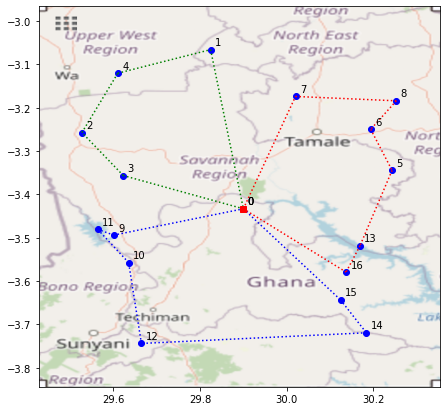

In [14]:
def loop_finder(arc):
    starting_list = []
    for i in range(0,len(arc)):
        if arc[i][0] == 0:
            starting_list.append(arc[i])
    sorted_list = []
    for i in range(0, len(starting_list)):
        sorted_list.append(starting_list[i])
        j = 0
        while j < len(arc):
            j += 1
            if sorted_list[-1][1]== arc[j][0]:
                sorted_list.append(arc[j])
                j = 0 
            if sorted_list[-1][1]== 0:
                j = len(arc)
    index = []
    for i in range(0,len(sorted_list)):
        if sorted_list[i][0]== 0:
            index.append(i)
    #print(len(index))
    index.append(len(sorted_list))
    loops = []
    for i in range(0,len(index)):
        loops.append(sorted_list[index[i-1]:index[i]])
    loops = loops[1:]
    return loops

#Plotting

BBox = ((min(long)-0.1,   max(long)+0.1,  min(lat)-0.1, max(lat)+0.1))
ruh_m = plt.imread('map.png')

active_arcs = [a for a in arcs if x[a].x > 0.99]
sorted_arcs = loop_finder(active_arcs)
fig, ax = plt.subplots(figsize = (8,7))
color = ['g','r','b','y','g','r','b','y','g','r','b','y','g','r','b','y']

linestyle = [':' ]
for k in range(len(sorted_arcs)):
    for i, j in sorted_arcs[k]:
        
        ax.plot([long[i], long[j]], [lat[i], lat[j]],color = color[k], linestyle= ':', zorder=1)  
        ax.annotate(nodes[i], (long[i]+0.01, lat[i]+0.01))
ax.plot(long[0], lat[0], c='r', marker='s')
ax.scatter(long[1:], lat[1:], c='b')

ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(ruh_m, zorder=0, extent = BBox, aspect= 'equal')
plt.show()



In [15]:
#for v in m.getVars():
       # print(str(v.VarName)+'='+str(v.x))
print(str(m.objVal/1000) + ' km')

442.69409748962687 km


NameError: name 'depo_long' is not defined

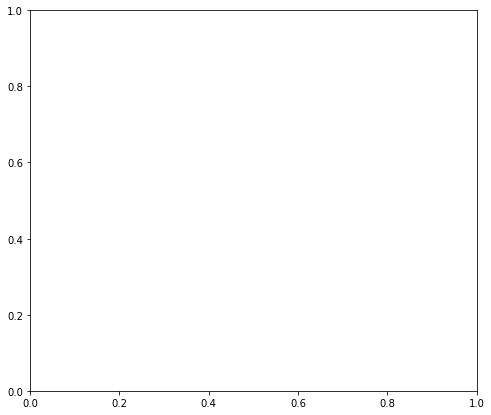

In [16]:
#Plotting
long = client_50['lon']
lat = client_50['lat']

BBox = ((min(long)-0.1,   max(long)+0.1,  min(lat)-0.1, max(lat)+0.1))
ruh_m = plt.imread('map.png')

fig, ax = plt.subplots(figsize = (8,7))

ax.plot(depo_long, depo_lat, c='r', marker='s')
ax.scatter(long, lat, c='b')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])

ax.imshow(ruh_m, zorder=0, extent = BBox, aspect= 'equal')
plt.show()